### Setup the Spark VM and complete the below assignment

Objective:- Build a ML model to predict the employee compensation.
The application should be modelled using Spark.

You can refer to the below links for spark commands:- 
- https://spark.apache.org/docs/latest/ml-pipeline.html

- https://github.com/spark-in-action/first-edition

- https://github.com/FavioVazquez/first_spark_model

# Predicting Employee Compensation

## Data Dictionary
<br>**Year Type** - Fiscal (July through June) or Calendar (January through December)
<br>**Year** - An accounting period of 12 months. The City and County of San Francisco operates on a fiscal year that begins on July 1 and ends on June 30 the following year. The Fiscal Year ending June 30, 2012 is represented as FY2011-2012.
<br>**Organization Group Code** - Org Group is a group of Departments. For example, the Public Protection Org Group includes departments such as the Police,Fire, Adult Probation, District Attorney, and Sheriff.
<br> **Organization Group** - Org Group is a group of Departments. For example, the Public Protection Org Group includes departments such as the Police,
Fire, Adult Probation, District Attorney, and Sheriff.
<br>**Department Code** - Departments are the primary organizational unit used by the Cityand County of San Francisco. Examples include Recreation and
Parks, Public Works, and the Police Department.
<br>**Department Code** - Departments are the primary organizational unit used by the City and County of San Francisco. Examples include Recreation and Parks, Public Works, and the Police Department.
<br>**Union Code** - Unions represent employees in collective bargaining agreements. A job belongs to one union, although some jobs are unrepresented (usually temporarily).
<br>**Union** - Unions represent employees in collective bargaining agreements. A job belongs to one union, although some jobs are unrepresented (usually temporarily).
<br>**Job Family Code** Job Family combines similar Jobs into meaningful groups.
<br>**Job Family** Job Family combines similar Jobs into meaningful groups.
<br>**Employee Identifier** Each distinct number in the “Employee Identifier” column represents one employee. These identifying numbers are not meaningful but rather are randomly assigned for the purpose of building this dataset. The column does not appear on the
Employee Compensation report hosted on openbook.sfgov.org,
but that report does show one row for each employee. Employee
ID has been included here to allow users to reconstruct the
original report. Note that each employee’s identifier will change
each time this dataset is updated, so comparisons by employee
across multiple versions of the dataset are not possible.
<br>**Salaries** - Normal salaries paid to permanent or temporary City employees.
<br>**Overtime** - Amounts paid to City employees working in excess of 40 hours
per week.
<br>**Other Salaries** - Various irregular payments made to City employees including premium pay, incentive pay, or other one-time payments. Total Salary Number The sum of all salaries paid to City employees.
<br>**Retirement** City contributions to employee retirement plans.
<br>**Health/Dental** City-paid premiums to health and dental insurance plans covering City employees. To protect confidentiality as legally required, pro-rated citywide averages are presented in lieu of employee-specific health and dental benefits.
<br>**Other Benefits** Mandatory benefits paid on behalf of employees, such as Social Security (FICA and Medicare) contributions, unemployment
insurance premiums, and minor discretionary benefits not included in the above categories.
<br>**Total Benefits** The sum of all benefits paid to City employees.
<br>**Total Compensation** The sum of all salaries and benefits paid to City employees.

Read the data and answer the following questions to predict employee compensation

## 1. Read the Data

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DoubleType

In [2]:
spark = SparkSession.builder \
    .appName("Employee Compensation") \
    .getOrCreate()

23/07/16 13:12:36 WARN Utils: Your hostname, 5CG1165DMB resolves to a loopback address: 127.0.1.1; using 192.168.0.107 instead (on interface wlp0s20f3)
23/07/16 13:12:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/16 13:12:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/07/16 13:12:38 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
data_path = "Employee_Compensation.csv"
employee_df = spark.read.csv(data_path, header=True, inferSchema=True)
# Convert DataFrame into a temporary view
employee_df.createOrReplaceTempView("employee")
employee_df.show()

+---------+----+-----------------------+--------------------+---------------+--------------------+----------+--------------------+---------------+--------------------+--------+--------------------+-------------------+---------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+
|Year Type|Year|Organization Group Code|  Organization Group|Department Code|          Department|Union Code|               Union|Job Family Code|          Job Family|Job Code|                 Job|Employee Identifier| Salaries|Overtime|Other Salaries|Total Salary|Retirement|Health/Dental|Other Benefits|Total Benefits|Total Compensation|
+---------+----+-----------------------+--------------------+---------------+--------------------+----------+--------------------+---------------+--------------------+--------+--------------------+-------------------+---------+--------+--------------+------------+----------+-------------+--------------+--------------+---

### 1.1 Display the number of rows and columns in the dataset

In [5]:
# Count the number of rows
num_rows = employee_df.count()
print(f"Number of rows: {num_rows}")

# Count the number of columns
num_columns = len(employee_df.columns)
print(f"Number of columns: {num_columns}")

Number of rows: 291825
Number of columns: 22


### 1.2 Check the datatype of the variables

In [6]:
# Check the data types of the variables
variable_types = employee_df.dtypes

# Print the variable name and its corresponding data type
for variable in variable_types:
    print(f"Variable: {variable[0]}, Data Type: {variable[1]}")

Variable: Year Type, Data Type: string
Variable: Year, Data Type: int
Variable: Organization Group Code, Data Type: int
Variable: Organization Group, Data Type: string
Variable: Department Code, Data Type: string
Variable: Department, Data Type: string
Variable: Union Code, Data Type: int
Variable: Union, Data Type: string
Variable: Job Family Code, Data Type: string
Variable: Job Family, Data Type: string
Variable: Job Code, Data Type: string
Variable: Job, Data Type: string
Variable: Employee Identifier, Data Type: int
Variable: Salaries, Data Type: double
Variable: Overtime, Data Type: double
Variable: Other Salaries, Data Type: double
Variable: Total Salary, Data Type: double
Variable: Retirement, Data Type: double
Variable: Health/Dental, Data Type: double
Variable: Other Benefits, Data Type: double
Variable: Total Benefits, Data Type: double
Variable: Total Compensation, Data Type: double


### 2. Convert the incorrect column type into its suitable column type. And drop the redundant features

In [7]:
# Convert incorrect column types
employee_df = employee_df.withColumn("Year", employee_df[1].cast("string"))
employee_df = employee_df.withColumn("Organization Group Code", employee_df[3].cast("string"))
employee_df = employee_df.withColumn("Union Code", employee_df[7].cast("string"))
employee_df = employee_df.withColumn("Employee Identifier", employee_df[13].cast("string"))

# Drop redundant features
redundant_features = ["Year Type", "Department Code", "Job Family Code", "Job Code"]
employee_df = employee_df.drop(*redundant_features)

# Check the updated data types
variable_types = employee_df.dtypes
for variable in variable_types:
    print(f"Variable: {variable[0]}, Data Type: {variable[1]}")

Variable: Year, Data Type: string
Variable: Organization Group Code, Data Type: string
Variable: Organization Group, Data Type: string
Variable: Department, Data Type: string
Variable: Union Code, Data Type: string
Variable: Union, Data Type: string
Variable: Job Family, Data Type: string
Variable: Job, Data Type: string
Variable: Employee Identifier, Data Type: string
Variable: Salaries, Data Type: double
Variable: Overtime, Data Type: double
Variable: Other Salaries, Data Type: double
Variable: Total Salary, Data Type: double
Variable: Retirement, Data Type: double
Variable: Health/Dental, Data Type: double
Variable: Other Benefits, Data Type: double
Variable: Total Benefits, Data Type: double
Variable: Total Compensation, Data Type: double


### 3. Check basic statistics and perform necessary data preprocessing (Like removing negative amount)

In [8]:
from pyspark.sql.functions import col, when

# Check basic statistics
employee_df.describe().show()

# Remove negative amounts
employee_df = employee_df.withColumn("Salaries", when(col("Salaries") < 0, 0).otherwise(col("Salaries")))
employee_df = employee_df.withColumn("Overtime", when(col("Overtime") < 0, 0).otherwise(col("Overtime")))
employee_df = employee_df.withColumn("Other Salaries", when(col("Other Salaries") < 0, 0).otherwise(col("Other Salaries")))
employee_df = employee_df.withColumn("Total Salary", when(col("Total Salary") < 0, 0).otherwise(col("Total Salary")))
employee_df = employee_df.withColumn("Retirement", when(col("Retirement") < 0, 0).otherwise(col("Retirement")))
employee_df = employee_df.withColumn("Health/Dental", when(col("Health/Dental") < 0, 0).otherwise(col("Health/Dental")))
employee_df = employee_df.withColumn("Other Benefits", when(col("Other Benefits") < 0, 0).otherwise(col("Other Benefits")))
employee_df = employee_df.withColumn("Total Benefits", when(col("Total Benefits") < 0, 0).otherwise(col("Total Benefits")))
employee_df = employee_df.withColumn("Total Compensation", when(col("Total Compensation") < 0, 0).otherwise(col("Total Compensation")))


23/07/16 14:43:22 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+-----------------------+--------------------+-------------------+--------------------+--------------------+--------------------+------------------+-------------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+
|summary|             Year|Organization Group Code|  Organization Group|         Department|          Union Code|               Union|          Job Family|               Job|Employee Identifier|         Salaries|          Overtime|   Other Salaries|     Total Salary|        Retirement|    Health/Dental|   Other Benefits|    Total Benefits|Total Compensation|
+-------+-----------------+-----------------------+--------------------+-------------------+--------------------+--------------------+--------------------+------------------+-------------------+-----------------+------------------+-----------------+-----------------+-----------

### 4. Perform Missing Value Analysis

In [9]:
from pyspark.sql.functions import col, sum

# Count the number of missing values in each column
missing_value_counts = employee_df.agg(*[
    sum(col(column).isNull().cast("int")).alias(column)
    for column in employee_df.columns
])

# Display the missing value counts
missing_value_counts.show()

+----+-----------------------+------------------+----------+----------+-----+----------+---+-------------------+--------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+
|Year|Organization Group Code|Organization Group|Department|Union Code|Union|Job Family|Job|Employee Identifier|Salaries|Overtime|Other Salaries|Total Salary|Retirement|Health/Dental|Other Benefits|Total Benefits|Total Compensation|
+----+-----------------------+------------------+----------+----------+-----+----------+---+-------------------+--------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+
|   0|                      0|                 0|         0|        43|   43|        45|  0|                  0|       0|       0|             0|           0|         0|            0|             0|             0|                 0|
+----+-----------------------+------------------+----------+--------

### 5. Exploratory Data Analysis

#### 5.1. Find top compensating organizations. Display using bar plot

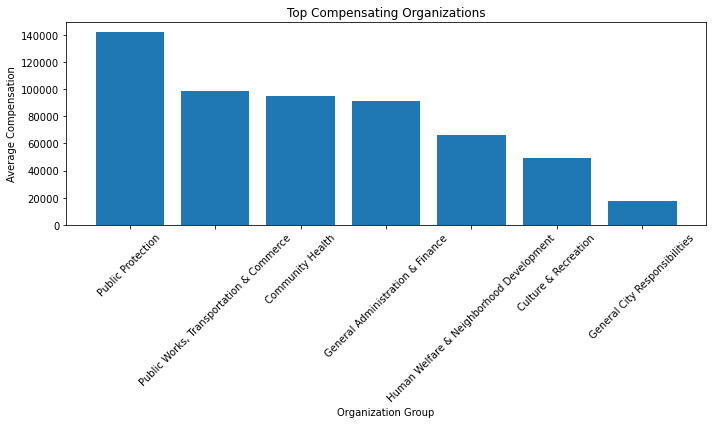

In [10]:
import matplotlib.pyplot as plt

# Group by Organization Group and calculate the average total compensation
org_compensation = employee_df.groupBy("Organization Group") \
    .agg({"Total Compensation": "mean"}) \
    .withColumnRenamed("avg(Total Compensation)", "Average Compensation") \
    .orderBy("Average Compensation", ascending=False)

# Convert the DataFrame to Pandas for visualization
org_compensation_pandas = org_compensation.toPandas()

# Generate the bar plot
plt.figure(figsize=(10, 6))
plt.bar(org_compensation_pandas["Organization Group"], org_compensation_pandas["Average Compensation"])
plt.xlabel("Organization Group")
plt.ylabel("Average Compensation")
plt.title("Top Compensating Organizations")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### 5.2. Find top Compensating Jobs. Display using bar plot

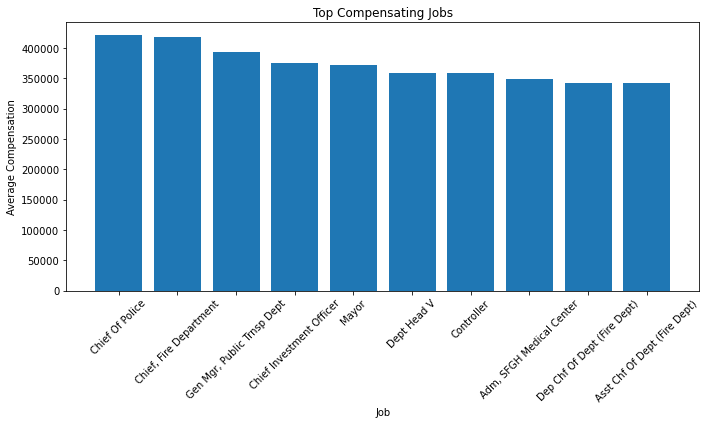

In [11]:
import matplotlib.pyplot as plt

# Group by Job and calculate the average total compensation
job_compensation = employee_df.groupBy("Job") \
    .agg({"Total Compensation": "mean"}) \
    .withColumnRenamed("avg(Total Compensation)", "Average Compensation") \
    .orderBy("Average Compensation", ascending=False)

# Convert the DataFrame to Pandas for visualization
job_compensation_pandas = job_compensation.toPandas()

# Filter the top 10 compensating jobs
top_jobs = job_compensation_pandas.head(10)

# Generate the bar plot
plt.figure(figsize=(10, 6))
plt.bar(top_jobs["Job"], top_jobs["Average Compensation"])
plt.xlabel("Job")
plt.ylabel("Average Compensation")
plt.title("Top Compensating Jobs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### 5.3. Check Correlation of Target Variable with Other Independent Variables. Plot Heatmap

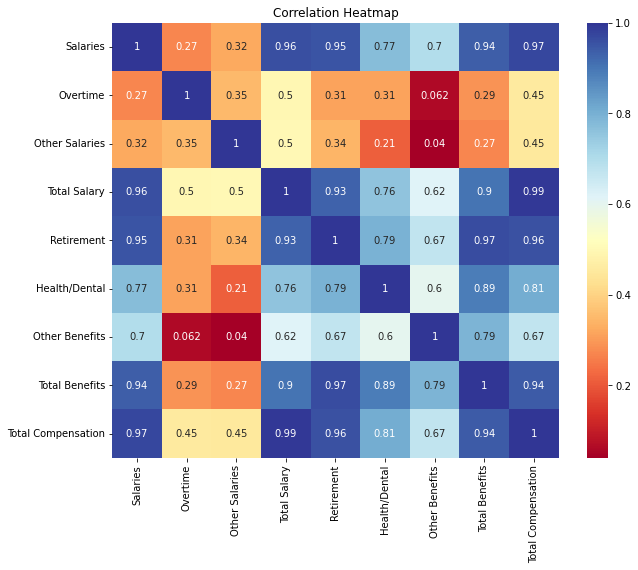

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the independent variables and the target variable
selected_columns = ["Salaries", "Overtime", "Other Salaries", "Total Salary", "Retirement",
                    "Health/Dental", "Other Benefits", "Total Benefits", "Total Compensation"]
selected_data = employee_df.select(*selected_columns)

# Compute the correlation matrix
correlation_matrix = selected_data.toPandas().corr()

# Generate the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="RdYlBu")
plt.title("Correlation Heatmap")
plt.show()


### 6. Perform necessary data pre-processing and divide the data into train and test set

### 6.1 Categorise the attributes into its type (Use one hot encoding wherever required)

In [15]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Categorize attributes into their respective types
categorical_cols = ["Organization Group", "Department", "Union", "Job Family", "Job"]
numerical_cols = ["Salaries", "Overtime", "Other Salaries", "Total Salary", "Retirement",
                  "Health/Dental", "Other Benefits", "Total Benefits", "Total Compensation"]

# Apply StringIndexer on categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="skip")
            for col in categorical_cols]

# Apply OneHotEncoder on indexed categorical columns
encoders = [OneHotEncoder(inputCols=[col + "_index"], outputCols=[col + "_encoded"])
            for col in categorical_cols]

# Create a pipeline for transformation
pipeline = Pipeline(stages=indexers + encoders)
categorized_df = pipeline.fit(employee_df).transform(employee_df)

# Select the encoded and numerical columns
selected_cols = [col + "_encoded" for col in categorical_cols] + numerical_cols
categorized_df = categorized_df.select(selected_cols)

# Display the resulting DataFrame
categorized_df.show()


+--------------------------+------------------+---------------+------------------+------------------+---------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+
|Organization Group_encoded|Department_encoded|  Union_encoded|Job Family_encoded|       Job_encoded| Salaries|Overtime|Other Salaries|Total Salary|Retirement|Health/Dental|Other Benefits|Total Benefits|Total Compensation|
+--------------------------+------------------+---------------+------------------+------------------+---------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+
|             (6,[2],[1.0])|   (53,[19],[1.0])|(72,[15],[1.0])|   (54,[16],[1.0])| (1135,[15],[1.0])|114473.16|     0.0|        1500.0|   115973.16|  21025.98|      13068.8|       9368.71|      43463.49|         159436.65|
|             (6,[4],[1.0])|   (53,[43],[1.0])| (72,[0],[1.0])|   (54,[14],[1.0])|(1135,[135],[1.0])| 84077.

### 6.2 Split the data into train and test set

In [16]:
# Split the data into train and test sets
train_ratio = 0.8  # Set the ratio for the train set
test_ratio = 1 - train_ratio

# Perform the split
train_data, test_data = employee_df.randomSplit([train_ratio, test_ratio], seed=42)

# Print the number of records in each set
print("Train set count:", train_data.count())
print("Test set count:", test_data.count())


Train set count: 233725


Test set count: 58100


### 7. Fit Linear Regression model on the data and check its performance

In [18]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Define the features and target variable
features = ["Salaries", "Overtime", "Other Salaries", "Total Salary", "Retirement",
            "Health/Dental", "Other Benefits", "Total Benefits"]
target = "Total Compensation"

# Create a vector assembler to combine the features into a feature vector column
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Transform the training and test data using the vector assembler
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# Create the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol=target)

# Fit the model on the training data
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model's performance
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

# Print the root mean squared error (RMSE)
print("Root Mean Squared Error (RMSE):", rmse)


23/07/16 14:54:33 WARN Instrumentation: [3fc5a4b9] regParam is zero, which might cause numerical instability and overfitting.
23/07/16 14:54:34 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/07/16 14:54:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Root Mean Squared Error (RMSE): 86.4953564636894


### 8. Fit Decision Tree Regression model on the data and check its performance (Optional)

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='scaled_features', labelCol = 'Total Compensation')
dt_model = dt.fit(trainDF)

### Model Persistence (Optional)
Model persistence means saving your model to a disk. After you finalize your model for prediction depending upon the performance, you need to save the model to the disk. Let's say, you finalize 'lrmodel' to be used for in production environment i.e. in your application. We use the following code to save it.

##### Saving the model

In [ ]:
# use save() method to save the model
# write().overwrite() is usually used when you want to replace the older model with a new one
# It might happen that you wish to retrain your model and save it at the same the place
lrmodel.write().overwrite().save("/FileStore/models/lrmodel")

##### Loading the model

In [ ]:
# import PipelineModel from pyspark.ml package
from pyspark.ml import PipelineModel

# load the model from the location it is stored
# The loaded model acts as PipelineModel
pipemodel = PipelineModel.load("/FileStore/models/lrmodel")

# use the PipelineModel object to perform prediciton on test data. 
# Use .transform() to perfrom prediction
prediction = pipemodel.transform(testDF)

# print the results
prediction.select('label', 'rawPrediction', 'probability', 'prediction').show(5)